In [1]:
import dask.dataframe as dd
import os
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
final_dataset_path = '..\data\FEData_For_Modelling.parquet'

# Read the multi-part Parquet dataset
fds = dd.read_parquet(final_dataset_path)
fds.head(4000)

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810


OWH: Outside Work Hours  
WH: Work Hours  
WKE: Weekend  
  
FC: files copied  
SD: Sus Domain  
CD: Cloud Domain  
JD: Job Domain  


In [3]:
def list_files_in_folder(folder_path):
    files = []
    # Check if the folder path exists
    if os.path.exists(folder_path):
        # Iterate through all files in the folder
        for file_name in os.listdir(folder_path):
            # Check if the path is a file (not a directory)
            if os.path.isfile(os.path.join(folder_path, file_name)):
                files.append(file_name[7:-4])
    else:
        print(f"Folder '{folder_path}' does not exist.")
    return files

sus_users_list = list_files_in_folder("..\data\\r5.2-2")
fds["targetLabel"] = fds['user'].apply(lambda x: 1 if x in sus_users_list else 0, meta=('int'))

In [4]:
print("How many sus users: ",len(sus_users_list))
print(sus_users_list)

How many sus users:  30
['BYO1846', 'CHP1711', 'CIF1430', 'CKP0630', 'DCC1119', 'GWG0497', 'HIS1394', 'HMS1658', 'HSN0675', 'HXP0976', 'ICB1354', 'ITA0159', 'JAL0811', 'KSS1005', 'LVF1626', 'MCP0611', 'MDS0680', 'MGB1235', 'NAH1366', 'OKM1092', 'OSS1463', 'RRS0056', 'SIS0042', 'SNK1280', 'TMT0851', 'TNB1616', 'TRC1838', 'VCF1602', 'WDT1634', 'ZIE0741']


In [5]:
(fds["targetLabel"] == 1).sum().compute()

30

In [6]:
y = fds["targetLabel"].compute()
X = fds.drop(columns=["targetLabel",]).compute()
# X = fds.drop(columns=["targetLabel","user"]).compute()

In [7]:
X_train_w_name, X_test_w_name, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_test = X_train_w_name.drop(columns=["user",]), X_test_w_name.drop(columns=["user",])

from sklearn.preprocessing import StandardScaler
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
# Create a One-Class SVM model
clf = OneClassSVM(nu=0.1) 
# Fit the model on the training data
clf.fit(X_train_scaled, y_train) 

OneClassSVM(nu=0.1)

##############################
Train Evaluation
##############################
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1376
           1       0.01      0.08      0.02        24

    accuracy                           0.89      1400
   macro avg       0.50      0.49      0.48      1400
weighted avg       0.97      0.89      0.92      1400



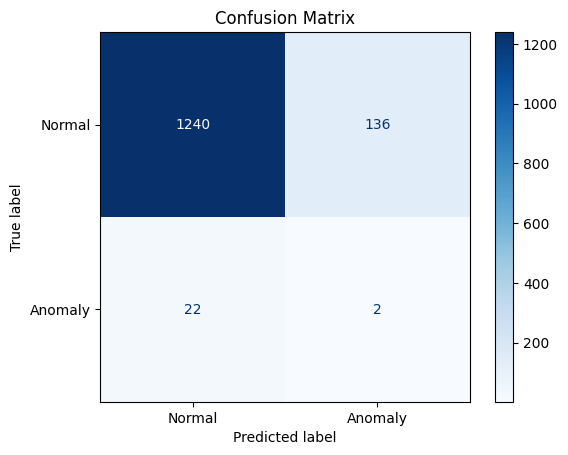


##############################
Test Evaluation
##############################
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       594
           1       0.01      0.17      0.02         6

    accuracy                           0.87       600
   macro avg       0.50      0.52      0.48       600
weighted avg       0.98      0.87      0.92       600



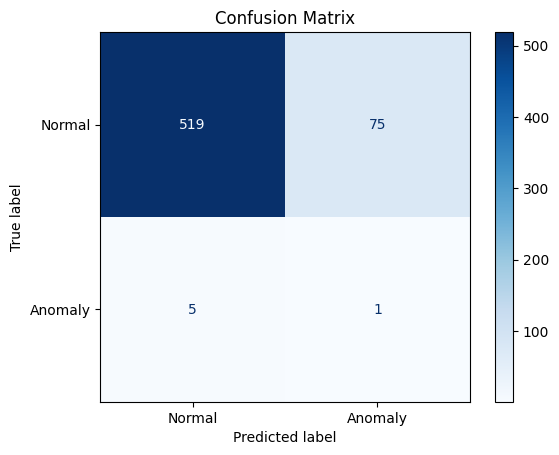

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
def eval_svm(preds, labels):

    # Convert predictions (-1 for outliers, 1 for inliers) to binary labels (0 for normal, 1 for anomaly)
    pred_labels = np.where(preds == -1, 1, 0)
    print(classification_report(labels, pred_labels))

    conf_matrix = confusion_matrix(labels, pred_labels)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                   display_labels=["Normal", "Anomaly"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

train_pred = clf.predict(X_train_scaled)
print("##############################")
print("Train Evaluation")
print("##############################")
eval_svm(train_pred, y_train)

print()

test_pred = clf.predict(X_test_scaled)
print("##############################")
print("Test Evaluation")
print("##############################")
eval_svm(test_pred, y_test)

## Risk scores

In [10]:
def get_risk_score(clf, X):
    def min_max_scaling(value, new_min, new_max):
        old_min = min(value)
        old_max = max(value)
        scaled_value = ((value - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min
        return scaled_value
    
    # distance from decision boundary where negative = non anomaly and positive = anomaly
    distances = clf.decision_function(X)
    risk_scores = min_max_scaling(distances, -1,1)
    
    return risk_scores


In [11]:
train_risk = get_risk_score(clf, X_train_scaled)
test_risk = get_risk_score(clf, X_test_scaled)

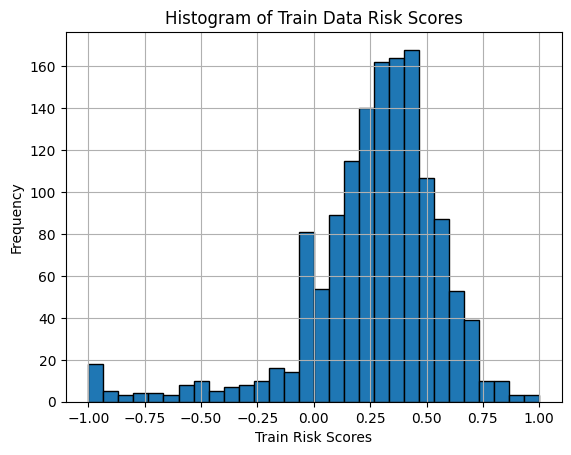

In [12]:
# Plot histogram
plt.hist(train_risk, bins=30, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Train Risk Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Train Data Risk Scores')
plt.grid(True)
plt.show()

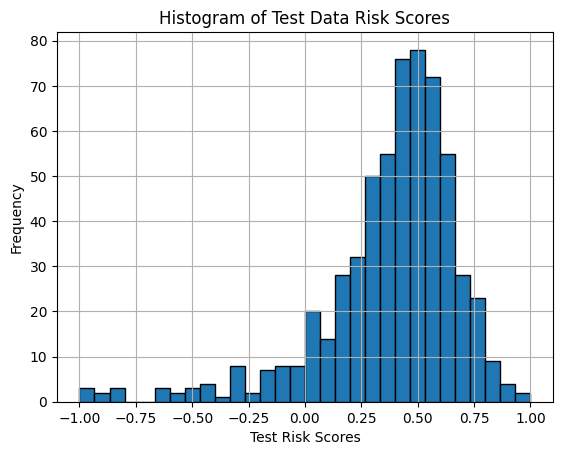

In [13]:
import matplotlib.pyplot as plt
# Plot histogram
plt.hist(test_risk, bins=30, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Test Risk Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Test Data Risk Scores')
plt.grid(True)
plt.show()

In [14]:
print("Example Train Risk Scores:")
print(train_risk[:10])  
print("\nExample Test Risk Scores:")
print(test_risk[:10])

Example Train Risk Scores:
[ 0.11514062 -0.54570138  0.45824576  0.55249862  0.08537697 -0.00144823
 -0.04699282  0.25504552 -0.05633844  0.22082429]

Example Test Risk Scores:
[ 0.63654647  0.09971012  0.3269887   0.63454985  0.75381267  0.27843421
  0.57992569  0.55179115 -0.332364    0.42565781]


## Export CSV of FP and FN names for entire dataset

In [15]:
train_pred = np.where(train_pred == -1, 1, 0)
test_pred = np.where(test_pred == -1, 1, 0)

In [16]:
# Filter out empty entries before concatenating
fp_train_names = X_train_w_name.iloc[np.where((y_train == 0) & (train_pred == 1))[0]]["user"]
fp_train_names = fp_train_names[fp_train_names.notnull()]  # Filter out NaNs if any
fp_test_names = X_test_w_name.iloc[np.where((y_test == 0) & (test_pred == 1))[0]]["user"]
fp_test_names = fp_test_names[fp_test_names.notnull()]  # Filter out NaNs if any
fn_train_names = X_train_w_name.iloc[np.where((y_train == 1) & (train_pred == 0))[0]]["user"]
fn_train_names = fn_train_names[fn_train_names.notnull()]  # Filter out NaNs if any
fn_test_names = X_test_w_name.iloc[np.where((y_test == 1) & (test_pred == 0))[0]]["user"]
fn_test_names = fn_test_names[fn_test_names.notnull()]  # Filter out NaNs if any

# Concatenate false positives and false negatives dataframes
fp_names = pd.concat([fp_train_names, fp_test_names], ignore_index=True)
fn_names = pd.concat([fn_train_names, fn_test_names], ignore_index=True)
# Create a dictionary with fp and fn dataframes
data = {'False Positives': fp_names, 'False Negatives': fn_names}

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Export the DataFrame to a CSV file
df.to_csv('fp_fn_names.csv', index=False)

In [17]:
fn_names

0     HXP0976
1     OSS1463
2     SNK1280
3     CHP1711
4     VCF1602
5     JAL0811
6     CKP0630
7     GWG0497
8     MDS0680
9     TRC1838
10    RRS0056
11    BYO1846
12    HSN0675
13    ITA0159
14    ZIE0741
15    CIF1430
16    KSS1005
17    HMS1658
18    HIS1394
19    LVF1626
20    WDT1634
21    MGB1235
22    OKM1092
23    TNB1616
24    MCP0611
25    ICB1354
26    NAH1366
Name: user, dtype: string